In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

In [2]:
# check device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
# hyperparameters
learning_rate = 0.001
epochs = 30
batch_size = 128
num_classes = 10    # 0-9 digits

In [4]:
# define transforms for training data
train_transform = transforms.Compose(
    [
        transforms.Resize((32, 32)),
        transforms.Grayscale(num_output_channels=3),  # Convert to three channels
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,)),
    ]
)

# define transforms for validation data
val_transform = transforms.Compose(
    [
        transforms.Resize((32, 32)),
        transforms.Grayscale(num_output_channels=3),  # Convert to three channels
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,)),
    ]
)

In [5]:
# download and load training dataset
train_dataset = torchvision.datasets.MNIST(
    root='./data', train=True, transform=train_transform, download=True
)

# download and load validation dataset
val_dataset = torchvision.datasets.MNIST(
    root='./data', train=False, transform=val_transform, download=True
)

# train data loader
train_loader = torch.utils.data.DataLoader(
    dataset=train_dataset, batch_size=batch_size, shuffle=True, num_workers=2
)

# validation data loader
val_loader = torch.utils.data.DataLoader(
    dataset=val_dataset, batch_size=batch_size, shuffle=False, num_workers=2
)

In [6]:
# load pretrained model VGG19 with batch normalization
model = torchvision.models.vgg19_bn(pretrained=True)
# change the last layer to fit our task
model.classifier[6] = nn.Linear(4096, num_classes)

/home/nckusoc/miniconda3/envs/cv/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/nckusoc/miniconda3/envs/cv/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_BN_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_BN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [7]:
# move model to device
model.to(device)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

In [8]:
# define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [9]:
# record loss and accuracy for each epoch
train_loss, train_acc = [], []
val_loss, val_acc = [], []

In [10]:
# train the model

for epoch in range(epochs):
    print(f'\nEpoch {epoch+1:2d}/{epochs:2d}')
    # training
    model.train()
    running_loss = 0.0
    running_acc = 0.0
    for images, labels in tqdm(train_loader):
        # move data to device
        images = images.to(device)
        labels = labels.to(device)

        # forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # record loss and accuracy
        running_loss += loss.item()
        _, preds = torch.max(outputs.data, 1)
        running_acc += torch.sum(preds == labels.data).item() / images.size(0)

    epoch_loss = running_loss / len(train_loader)
    epoch_acc = running_acc / len(train_loader)
    train_loss.append(epoch_loss)
    train_acc.append(epoch_acc)

    # validation
    model.eval()
    with torch.no_grad():
        running_loss = 0.0
        running_acc = 0.0
        for images, labels in tqdm(val_loader):
            # move data to device
            images = images.to(device)
            labels = labels.to(device)

            # forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # record loss and accuracy
            running_loss += loss.item()
            _, preds = torch.max(outputs.data, 1)
            running_acc += torch.sum(preds == labels.data).item() / images.size(0)

        epoch_loss = running_loss / len(val_loader)
        epoch_acc = running_acc / len(val_loader)
        val_loss.append(epoch_loss)
        val_acc.append(epoch_acc)

    print(f'Epoch {epoch+1:2d} | Train Loss: {train_loss[-1]:.4f} | Train Acc: {train_acc[-1]:.4f} | Val Loss: {val_loss[-1]:.4f} | Val Acc: {val_acc[-1]:.4f}')


Epoch  1/30


100%|██████████| 79/79 [00:00<00:00, 92.93it/s] 


Epoch  1 | Train Loss: 0.3201 | Train Acc: 0.9349 | Val Loss: 0.4715 | Val Acc: 0.9134

Epoch  2/30


100%|██████████| 79/79 [00:00<00:00, 93.99it/s]


Epoch  2 | Train Loss: 0.8902 | Train Acc: 0.7945 | Val Loss: 0.5814 | Val Acc: 0.7856

Epoch  3/30


100%|██████████| 79/79 [00:00<00:00, 97.47it/s] 


Epoch  3 | Train Loss: 0.2970 | Train Acc: 0.9022 | Val Loss: 0.1048 | Val Acc: 0.9698

Epoch  4/30


100%|██████████| 79/79 [00:00<00:00, 92.57it/s] 


Epoch  4 | Train Loss: 0.1067 | Train Acc: 0.9707 | Val Loss: 0.0834 | Val Acc: 0.9785

Epoch  5/30


100%|██████████| 79/79 [00:00<00:00, 93.81it/s]


Epoch  5 | Train Loss: 0.0704 | Train Acc: 0.9813 | Val Loss: 0.0576 | Val Acc: 0.9857

Epoch  6/30


100%|██████████| 79/79 [00:00<00:00, 98.42it/s] 


Epoch  6 | Train Loss: 0.0545 | Train Acc: 0.9861 | Val Loss: 0.0420 | Val Acc: 0.9879

Epoch  7/30


100%|██████████| 79/79 [00:00<00:00, 92.43it/s] 


Epoch  7 | Train Loss: 0.0523 | Train Acc: 0.9871 | Val Loss: 0.0503 | Val Acc: 0.9894

Epoch  8/30


100%|██████████| 79/79 [00:00<00:00, 95.61it/s] 


Epoch  8 | Train Loss: 0.0466 | Train Acc: 0.9888 | Val Loss: 0.0503 | Val Acc: 0.9890

Epoch  9/30


100%|██████████| 79/79 [00:00<00:00, 98.24it/s] 


Epoch  9 | Train Loss: 0.0412 | Train Acc: 0.9901 | Val Loss: 0.0414 | Val Acc: 0.9891

Epoch 10/30


100%|██████████| 79/79 [00:00<00:00, 92.90it/s] 


Epoch 10 | Train Loss: 0.0394 | Train Acc: 0.9911 | Val Loss: 0.0601 | Val Acc: 0.9874

Epoch 11/30


100%|██████████| 79/79 [00:00<00:00, 94.05it/s]


Epoch 11 | Train Loss: 0.0411 | Train Acc: 0.9901 | Val Loss: 0.0604 | Val Acc: 0.9871

Epoch 12/30


100%|██████████| 79/79 [00:00<00:00, 92.52it/s] 


Epoch 12 | Train Loss: 0.0510 | Train Acc: 0.9887 | Val Loss: 0.0576 | Val Acc: 0.9874

Epoch 13/30


100%|██████████| 79/79 [00:00<00:00, 93.38it/s] 


Epoch 13 | Train Loss: 0.0470 | Train Acc: 0.9895 | Val Loss: 0.0351 | Val Acc: 0.9922

Epoch 14/30


100%|██████████| 79/79 [00:00<00:00, 94.98it/s]


Epoch 14 | Train Loss: 1.1718 | Train Acc: 0.9327 | Val Loss: 233.2485 | Val Acc: 0.2102

Epoch 15/30


100%|██████████| 79/79 [00:00<00:00, 96.71it/s] 


Epoch 15 | Train Loss: 1.3653 | Train Acc: 0.6728 | Val Loss: 0.2761 | Val Acc: 0.9212

Epoch 16/30


100%|██████████| 79/79 [00:00<00:00, 94.19it/s] 


Epoch 16 | Train Loss: 0.9041 | Train Acc: 0.8803 | Val Loss: 0.2980 | Val Acc: 0.9141

Epoch 17/30


100%|██████████| 79/79 [00:00<00:00, 94.46it/s] 


Epoch 17 | Train Loss: 0.3824 | Train Acc: 0.9330 | Val Loss: 0.1409 | Val Acc: 0.9618

Epoch 18/30


100%|██████████| 79/79 [00:00<00:00, 97.64it/s] 


Epoch 18 | Train Loss: 0.2374 | Train Acc: 0.9597 | Val Loss: 0.0995 | Val Acc: 0.9733

Epoch 19/30


100%|██████████| 79/79 [00:00<00:00, 92.60it/s] 


Epoch 19 | Train Loss: 0.9411 | Train Acc: 0.8395 | Val Loss: 0.3502 | Val Acc: 0.8911

Epoch 20/30


100%|██████████| 79/79 [00:00<00:00, 94.61it/s] 


Epoch 20 | Train Loss: 0.3995 | Train Acc: 0.9174 | Val Loss: 0.1743 | Val Acc: 0.9489

Epoch 21/30


100%|██████████| 79/79 [00:00<00:00, 98.51it/s] 


Epoch 21 | Train Loss: 0.3359 | Train Acc: 0.9304 | Val Loss: 0.1708 | Val Acc: 0.9483

Epoch 22/30


100%|██████████| 79/79 [00:00<00:00, 94.39it/s] 


Epoch 22 | Train Loss: 0.3098 | Train Acc: 0.9371 | Val Loss: 0.3460 | Val Acc: 0.8917

Epoch 23/30


100%|██████████| 79/79 [00:00<00:00, 92.72it/s] 


Epoch 23 | Train Loss: 0.5798 | Train Acc: 0.9237 | Val Loss: 0.1414 | Val Acc: 0.9567

Epoch 24/30


100%|██████████| 79/79 [00:00<00:00, 97.64it/s] 


Epoch 24 | Train Loss: 0.1425 | Train Acc: 0.9606 | Val Loss: 0.1075 | Val Acc: 0.9690

Epoch 25/30


100%|██████████| 79/79 [00:00<00:00, 93.16it/s] 


Epoch 25 | Train Loss: 0.1101 | Train Acc: 0.9694 | Val Loss: 0.0791 | Val Acc: 0.9782

Epoch 26/30


100%|██████████| 79/79 [00:00<00:00, 92.62it/s] 


Epoch 26 | Train Loss: 0.0969 | Train Acc: 0.9734 | Val Loss: 0.0661 | Val Acc: 0.9819

Epoch 27/30


100%|██████████| 79/79 [00:00<00:00, 98.75it/s] 


Epoch 27 | Train Loss: 0.0842 | Train Acc: 0.9774 | Val Loss: 0.0790 | Val Acc: 0.9782

Epoch 28/30


100%|██████████| 79/79 [00:00<00:00, 92.78it/s]


Epoch 28 | Train Loss: 0.0734 | Train Acc: 0.9801 | Val Loss: 0.0594 | Val Acc: 0.9835

Epoch 29/30


100%|██████████| 79/79 [00:00<00:00, 92.53it/s] 


Epoch 29 | Train Loss: 0.0653 | Train Acc: 0.9826 | Val Loss: 0.0437 | Val Acc: 0.9881

Epoch 30/30


100%|██████████| 79/79 [00:00<00:00, 92.71it/s] 

Epoch 30 | Train Loss: 0.0577 | Train Acc: 0.9842 | Val Loss: 0.0505 | Val Acc: 0.9873


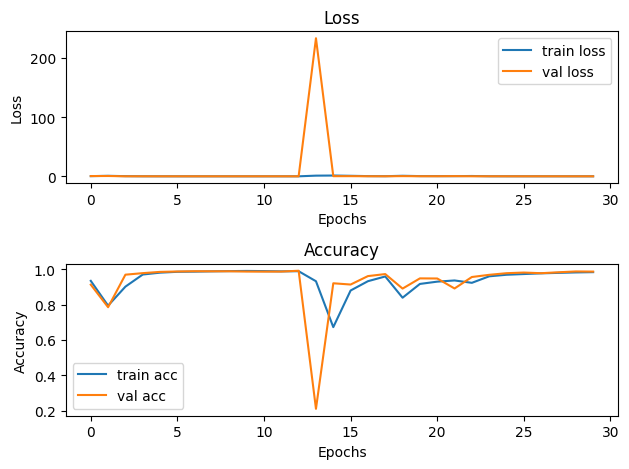

In [11]:
# plot loss and accuracy
plt.figure()
# loss
plt.subplot(2,1,1)
plt.plot(train_loss, label='train loss')
plt.plot(val_loss, label='val loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss')
# accuracy
plt.subplot(2,1,2)
plt.plot(train_acc, label='train acc')
plt.plot(val_acc, label='val acc')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy')
# save figure
plt.tight_layout()
plt.savefig('mnist.png')
plt.show()

In [12]:
# save model
torch.save(model.state_dict(), 'mnist.pth')